In [145]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft
import torch
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

We are exploring here the idea of "telescoping neural ratio estimation".

Instead of estimating
$$
\frac{p(z|x)}{p(z)}
$$
we instead estimate
$$
\frac{p(z|x)}{p'(z|x)}
$$
and
$$
\frac{p'(z|x)}{p(z)}
$$
and then multiply (add the log ratios).

The tricky aspect is now to define some telescoping distribution $p'(z|x)$ that

- ...is something intermediate between $p(z)$ and $p(z|x)$. Roughly speaking, it should be a broadned version of the posterior, more similar to the prior.
- ...still has the same marginal distribution as the origianl model, $p(z) = \int dx p'(z|x)p(x)$.

The second point is important since otherwise the ratio estimator just learns the difference between different distributions of $z$, not caring much about $x$.

We do this here by assuming that the prior is Gaussian. In that case, we can define a model
$$
z \sim p'(z|x) \quad \Leftrightarrow \quad z = \sqrt{a} z' + \sqrt{1-a} z'' \quad \text{with} \quad z' \sim p(z|x) 
\quad\text{and}\quad z'' \sim p(z)
$$
with $a\in [0, 1]$ is some tuneable parameter.

In [146]:
torch.manual_seed(0)
np.random.seed(0)

In [182]:
N = 30_000  # Number of samples
z = np.random.randn(N, 3)
zp = z
r = (zp[:,0]**2 + zp[:,1]**2 + 0.0*zp[:, 0]*z[:,1]*zp[:,2])**0.5
x = r.reshape(N, 1) + np.random.randn(N, 1)*0.05
samples = swyft.Samples(x = x, z = z)

In [196]:
class Network(swyft.AdamWReduceLROnPlateau, swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.compressor = torch.nn.LazyLinear(3)
        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 3, varnames = 'z', num_blocks = 4)
        self.logratios2 = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 3, varnames = 'z', num_blocks = 4)

    def forward(self, A, B):
        s = A['x']
        s, z = swyft.equalize_tensors(s, B['z'])
        a = 0.0001
        z1 = z*1
        z2 = z*1
        if self.training:    
            idx = torch.randperm(64)
            z1[:64] = z[:64]*a**0.5 + z[64:][idx]*(1-a)**0.5
            z2[64:] = z[:64]*a**0.5 + z[64:][idx]*(1-a)**0.5
        logratios1 = self.logratios1(s, z1)
        logratios2 = self.logratios2(s, z2)
        return logratios1, logratios2

In [197]:
trainer = swyft.SwyftTrainer(accelerator = DEVICE, precision = 64, max_epochs=10)
dm = swyft.SwyftDataModule(samples, batch_size = 64, shuffle = True)
network = Network()
trainer.fit(network, dm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | compressor | LazyLinear             | 0     
1 | logratios1 | LogRatioEstimator_1dim | 103 K 
2 | logratios2 | LogRatioEstimator_1dim | 103 K 
------------------------------------------------------
207 K     Trainable params
0         Non-trainable params
207 K     Total params
1.659     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Reloading best model: /Users/cweniger/Documents/swyft/notebooks/dev/lightning_logs/version_47/checkpoints/epoch=8-step=3375.ckpt


In [198]:
x0 = 0.5
obs = swyft.Sample(x = np.array([x0]))
prior_samples = swyft.Samples(z = np.random.rand(30_000, 3)*2-1)
predictions = trainer.infer(network, obs, prior_samples)
p0 = predictions[0]
p0.logratios = predictions[0].logratios + predictions[1].logratios

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 375it [00:00, ?it/s]

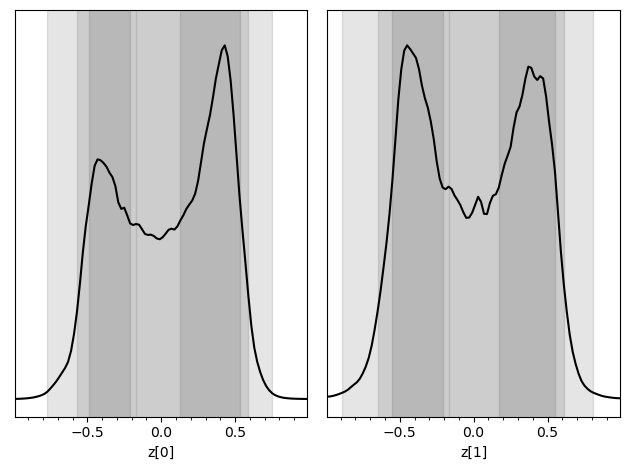

In [199]:
swyft.plot_posterior(p0, ["z[0]", "z[1]"], bins = 100, smooth = 1); # a = 0.0001

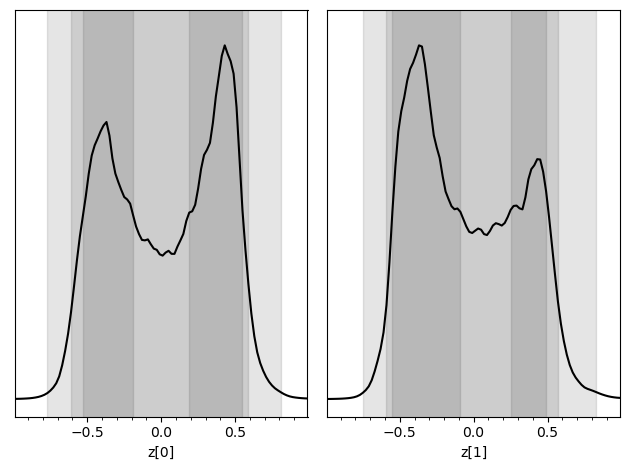

In [195]:
swyft.plot_posterior(p0, ["z[0]", "z[1]"], bins = 100, smooth = 1); # a = 0.9999

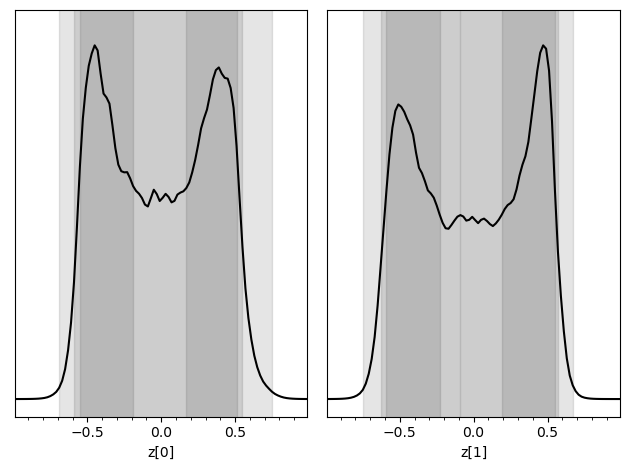

In [190]:
swyft.plot_posterior(p0, ["z[0]", "z[1]"], bins = 100, smooth = 1); # a = 0.95

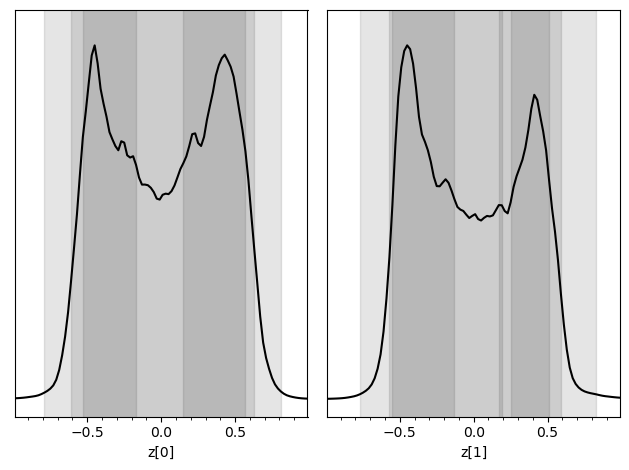

In [186]:
swyft.plot_posterior(p0, ["z[0]", "z[1]"], bins = 100, smooth = 1); # a = 0.05

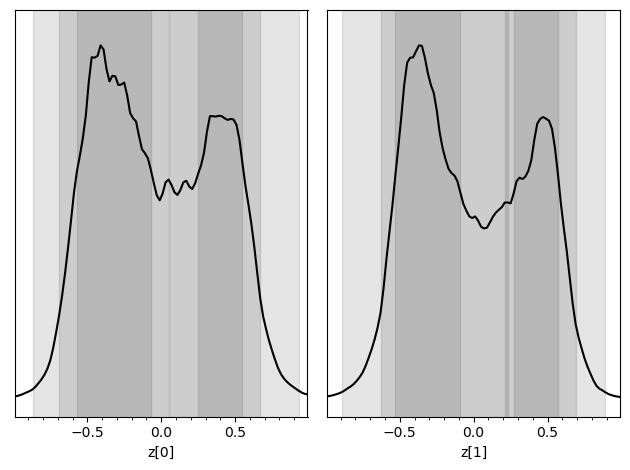

In [181]:
swyft.plot_posterior(p0, ["z[0]", "z[1]"], bins = 100, smooth = 1); # a = 0.05

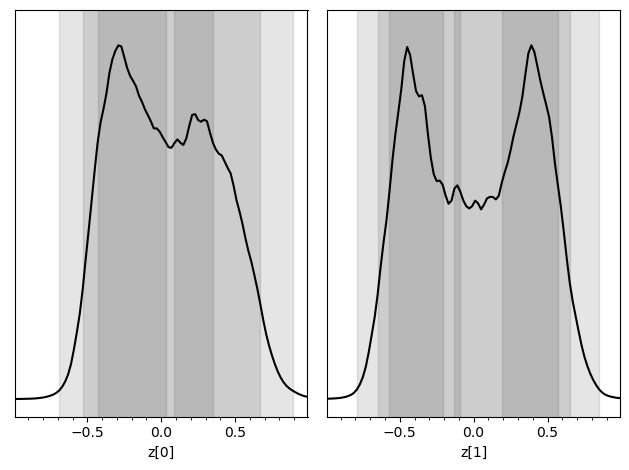

In [176]:
swyft.plot_posterior(p0, ["z[0]", "z[1]"], bins = 100, smooth = 1); # a = 0.05

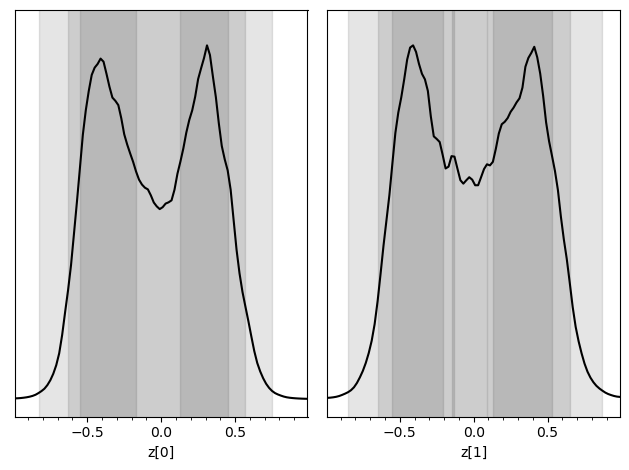

In [172]:
swyft.plot_posterior(p0, ["z[0]", "z[1]"], bins = 100, smooth = 1); # a = 0.5

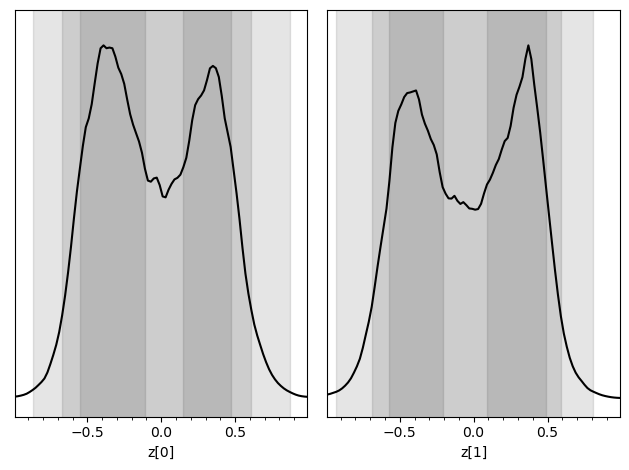

In [169]:
swyft.plot_posterior(p0, ["z[0]", "z[1]"], bins = 100, smooth = 1); # a = 0.5